# Quickstart: Collisional Ionization Equilibrium

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"e- conservation equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
e- conservation equation: Eq(Derivative(n_e-(t), t), -1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252))


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

## Solving ionization equilibrium

We would like to solve for ionization equilibrium given a temperature $T$, overall H number density $n_{\rm H,tot}$, and helium mass fraction $Y$.  We define a dictionary of those input quantities and also one for the initial guesses of the number densities of the species in the reduced network.

In [4]:
Tgrid = np.logspace(3,6,10**6) #np.logspace(4,4.3,10**6)
ngrid = np.ones_like(Tgrid) 

knowns = {"n_Htot": ngrid, "T": Tgrid}

Note that by default, the solver only directly solves for $n_{\rm H}$, $n_{\rm He}$ and $n_{\rm He+}$ because $n_{\rm H+}$, $n_{\rm He++}$, and $n_{\rm e-}$ are eliminated by conservation equations. So we only need initial guesses for those 3 quantities. By default the solver takes abundances $x_i = n_i / n_{\rm H,tot}$ as inputs and outputs.

In [ ]:
guesses = {
    "H": 0.5*np.ones_like(Tgrid),
    "He": 0.01*np.ones_like(Tgrid),
    "He+": 1e-4*np.ones_like(Tgrid),
}
#sol = system.solve(knowns, guesses)
subsystem = system.network.reduced(knowns)
#subsystem.rhs
subsystem
#len(subsystem.symbols) - len(knowns), list(knowns), subsystem.symbols
sol = system.solve(knowns,guesses,verbose=True,careful_steps=10,tol=1e-6)

Undetermined symbols: {y, x_He, x_H, T, x_He+, n_Htot}
y
y not specified; assuming y=0.09254634923706946.
x_He
x_H
T
x_He+
n_Htot
Free symbols: {y, x_He, x_H, T, x_He+, n_Htot}
 Known values: ['n_Htot', 'T']
 Assumed values: ['y'] Equations solved: ['He', 'He+', 'H']
It's morbin time. Solving for {'H', 'He', 'He+'} based on input {'n_Htot', 'T'} and assumptions about {'y'}
[59 59 59 ... 12 12 12]
{'x_He': Array([9.25463492e-02, 9.25463492e-02, 9.25463492e-02, ...,
       2.74936240e-09, 2.74930326e-09, 2.74924411e-09], dtype=float64), 'x_H': Array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       6.06120766e-07, 6.06114992e-07, 6.06109218e-07], dtype=float64), 'x_He+': Array([5.81853257e-21, 5.81853257e-21, 5.81853257e-21, ...,
       7.69222074e-06, 7.69213022e-06, 7.69203971e-06], dtype=float64), 'x_He++': Array([0.        , 0.        , 0.        , ..., 0.09253865, 0.09253865,
       0.09253865], dtype=float64), 'x_H+': Array([1.11022302e-16, 1.11022302e-16, 1.11022302e-16

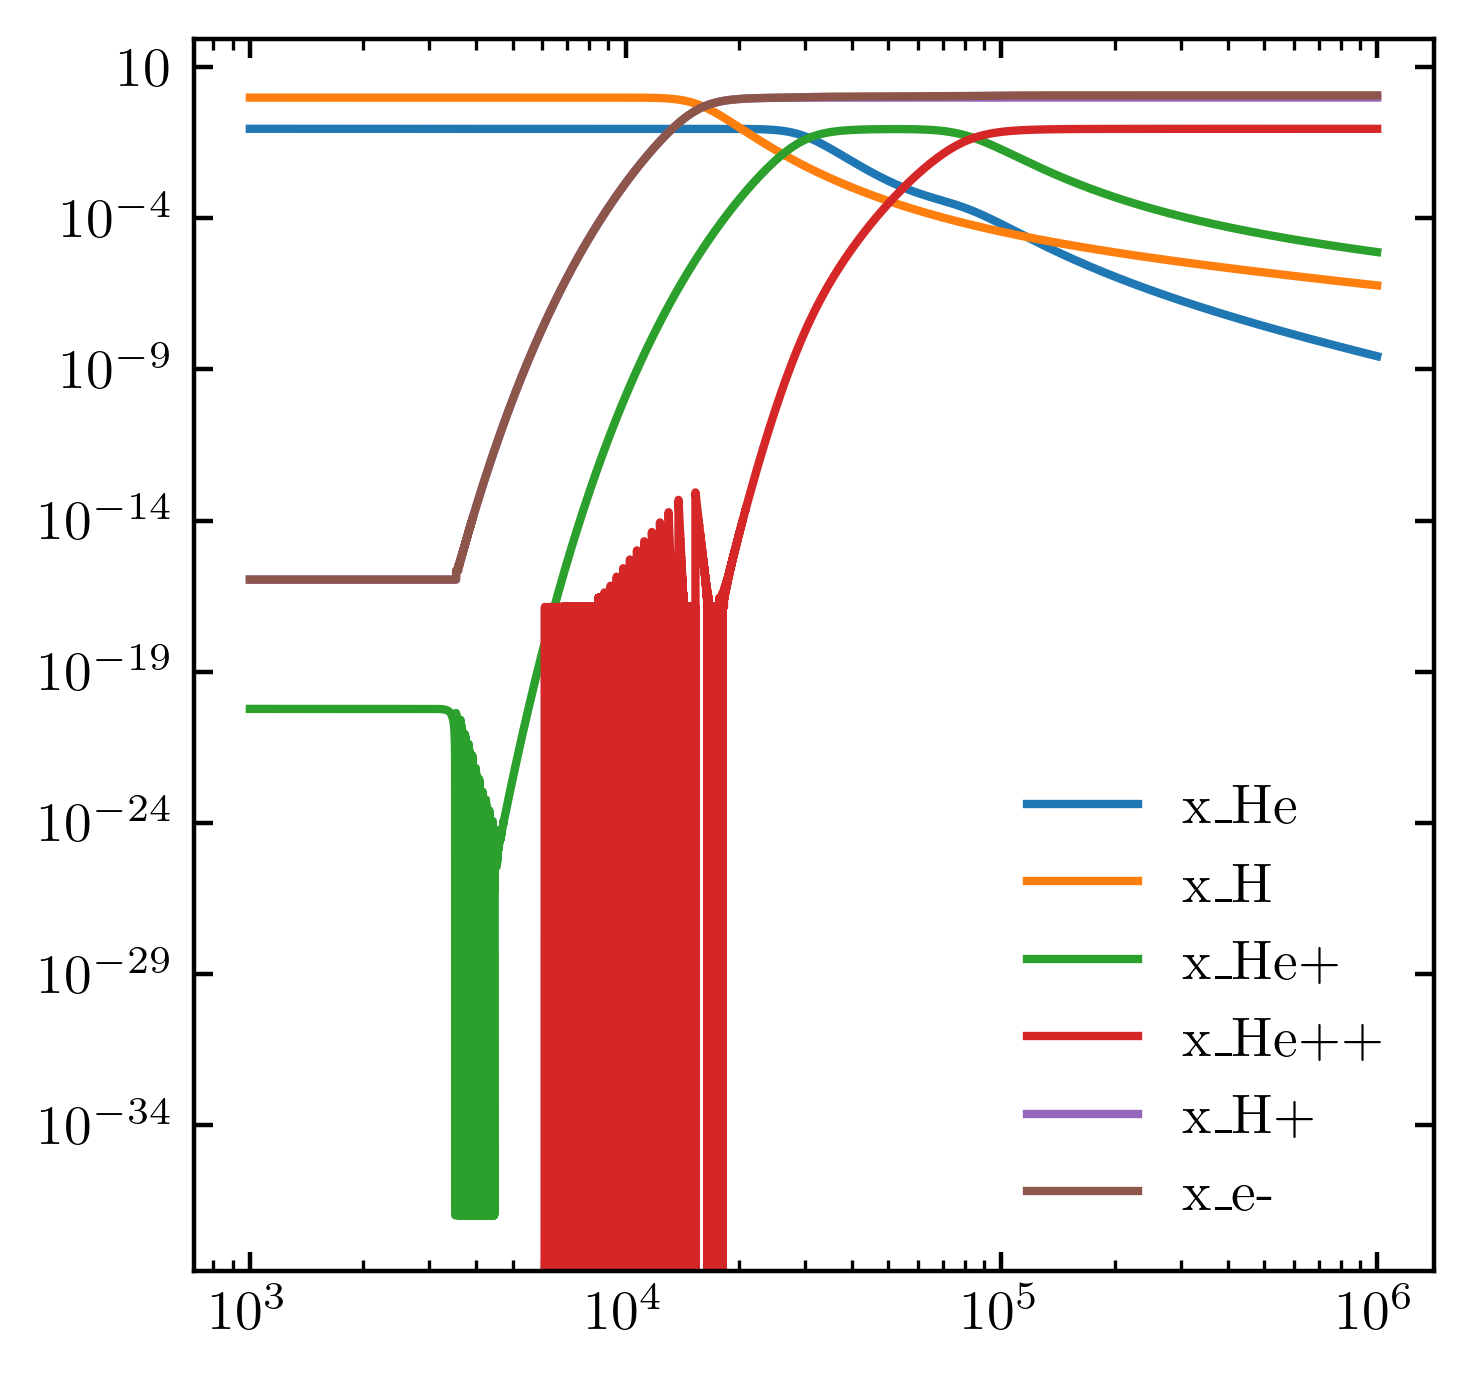

In [9]:
for k in sol:
    plt.loglog(Tgrid, sol[k],label=k)
plt.legend()
#plt.ylim(1e-3,2)
#sol

In [7]:
subsystem.rhs

{'He': -2.38e-11*sqrt(T)*n_Htot**2*x_He*(-x_H - 2*x_He - x_He+ + 2*y + 1)*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + n_Htot**2*x_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108))*(-x_H - 2*x_He - x_He+ + 2*y + 1),
 'He+': 2.38e-11*sqrt(T)*n_Htot**2*x_He*(-x_H - 2*x_He - x_He+ + 2*y + 1)*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.68e-12*sqrt(T)*n_Htot**2*x_He+*(-x_H - 2*x_He - x_He+ + 2*y + 1)*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_Htot**2*x_He+*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.93241606228058e-10/(sqrt(T)*(0.000164934781188511*sqrt(T) + 1.0)**1.7892*(4.84160744811772*sqrt(T) + 1.0)**0.2108))*(-x_H - 2*x_He - x_He+ + 2*y + 1) + 5.66485863480458e-10*n_Htot**2*(-x_He - x_He+ + y)*(-x_H - 2*x_He - x_He+ + 2*y + 1)/(sqrt(T)*(0.00059608348423851*sqrt(T) + 1.0)**1.748*(0.281807561832489*sqrt(T) + 1.0)**0.252),
 'H': -

(0.0001, 3)

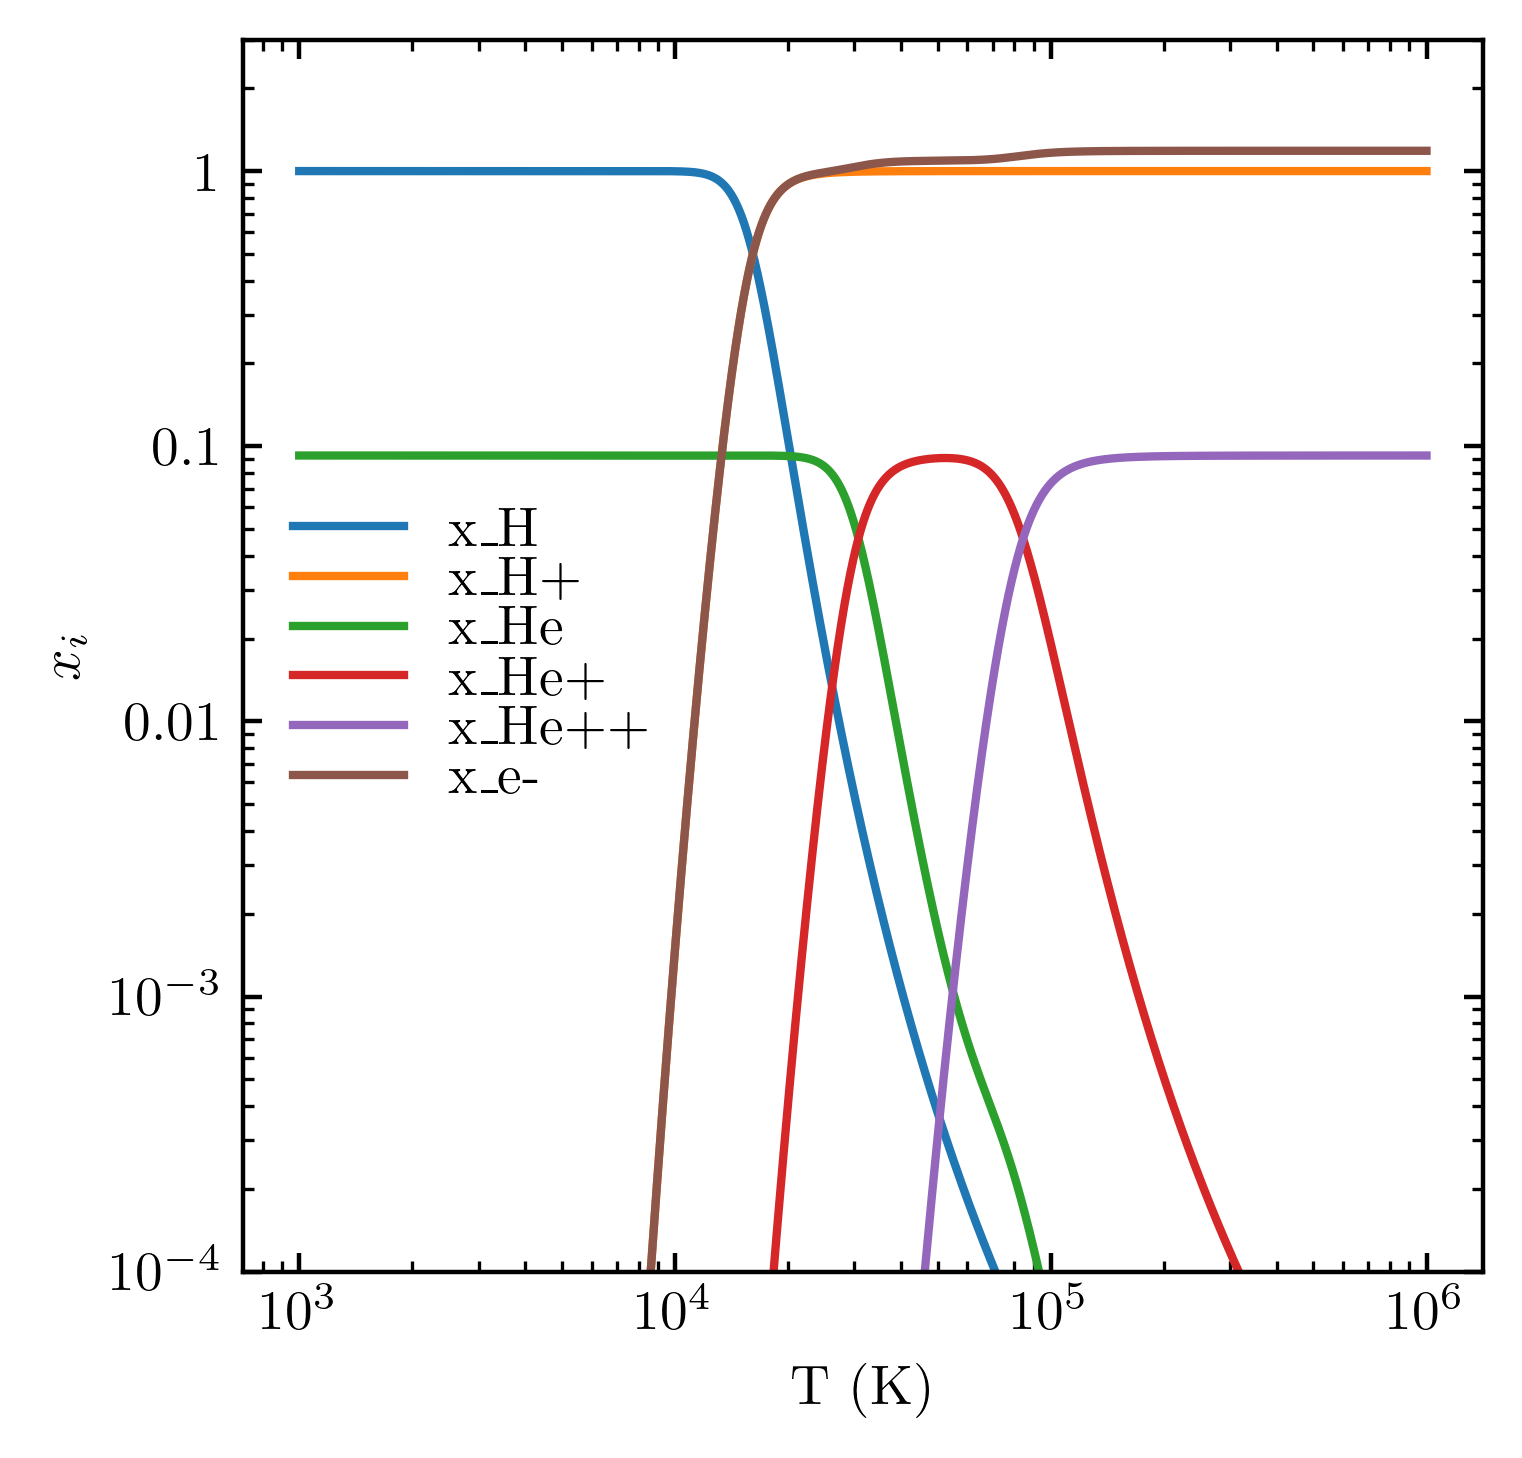

In [8]:
for i, xi in sorted(sol.items()):
    plt.loglog(Tgrid, xi, label=i)
plt.legend(labelspacing=0)
plt.ylabel("$x_i$")
plt.xlabel("T (K)")
plt.ylim(1e-4,3)